# setup

In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import mkdirifnotexists
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import re
import statsmodels
from datetime import datetime

curr_dir = mkdirifnotexists(os.path.join('preprocess_metabolon_data'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [3]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
_metabolon_may18_retired_unknows = os.path.join('additional_metabolon_files', 'WEIZ-01-18ML+ CDT retired unknowns 060618.xlsx')
_metabolon_mar20_retired_unknows = os.path.join('additional_metabolon_files', 'WEIZ-01-16ML+ and WEIZ-01-18ML+ Retired compounds.csv')

_metabolon_columns = ['SAMPLE_ID', 'SAMPLE_NAME', 'CLIENT_IDENTIFIER', 'BARCODE', 'BATCH', 'GROUP_NUMBER',
                      'COMMENT', 'StudyTypeID', 'RegistrationCode', 'StorageDT']

# Updates regarding molecules (Mar 2019)
_molecule_name_update_mar2019 = {'X - 12230': '4-ethylcatechol sulfate',
                                 'X - 12329': '3-hydroxy-2-methylpyridine sulfate',
                                 'X - 12837': 'glucuronide of C19H28O4 (2)*',
                                 'X - 14662': 'glycoursodeoxycholate sulfate (1)',
                                 'X - 16654': 'deoxycholic acid (12 or 24)-sulfate*',
                                 'X - 17145': 'branched chain 14:0 dicarboxylic acid**',
                                 'X - 17469': 'lithocholic acid sulfate (1)',
                                 'X - 18249': '3,5-dichloro-2,6-dihydroxybenzoic acid',
                                 'X - 18914': '3-bromo-5-chloro-2,6-dihydroxybenzoic acid*',
                                 'X - 23649': '3-hydroxypyridine glucuronide'}
# comments regarding molecules (Mar 2019)
_molecule_comment_update_mar2019 = {'X - 11315': 'elucidation in progress; may be an amino acid derivative',
                                    'X - 11640': 'has been named for enterolactone sulfate as of earlier this month',
                                    'X - 11843': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 11850': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12126': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12216': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12261': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12283': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12718': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 12738': 'candidate structure is phenol-related',
                                    'X - 13835': 'candidate structure is an aromatic amino acid related metabolite',
                                    'X - 13844': 'candidate structure is a benzoic acid derivative',
                                    'X - 17185': 'candidate structure is phenol-related',
                                    'X - 17354': 'candidate structure is polyphenol related',
                                    'X - 21286': 'candidate structure is pyridine related',
                                    'X - 22509': 'candidate structure is polyphenol related',
                                    'X - 22520': 'fatty acid conjugate',
                                    'X - 23639': "high priority internally, but don'left have a good guess right now",
                                    'X - 23655': 'candidate structure is pyridine related',
                                    'X - 24243': 'candidate structure is piperidine related',
                                    'X - 24410': 'candidate structure is piperidine related'}


# metabolomics_names = Defs.load_list('metabolomics_names')


def _update_molecule_comment_and_name_mar2019(metabs):
    """

    :param metabs:
    :return:
    """
    # update names
    metabs = metabs.replace({'BIOCHEMICAL': _molecule_name_update_mar2019})
    metabs['COMMENT'] = metabs['BIOCHEMICAL'].copy()
    # add comments
    metabs = metabs.replace({'COMMENT': _molecule_comment_update_mar2019})
    return metabs

def _update_retired_molecules_data(metabs):
    retired = pd.read_csv(_metabolon_mar20_retired_unknows, index_col=0)
    metabs_intersection = list(set(metabs.index).intersection(set(retired.index)))

    # for c in ['SUPER_PATHWAY', 'SUB_PATHWAY', 'BIOCHEMICAL']:
    for c in ['SUPER_PATHWAY', 'SUB_PATHWAY']:
        metabs.loc[metabs_intersection, c] = retired.loc[metabs_intersection, c]
    return metabs

def _load_may18_retired_unknows():
    metabolon_may18_retired_unknows = pd.read_excel(_metabolon_may18_retired_unknows, 'OrigScale',
                                                          header=None, engine='openpyxl')
    metabolon_may18_retired_unknows = metabolon_may18_retired_unknows.loc[
        metabolon_may18_retired_unknows[7].notnull()]
    metabolon_may18_retired_unknows_dic = {
        re.compile('(X - [0-9]+)').search(str(metabolon_may18_retired_unknows.loc[i, 7])).
            group(1): metabolon_may18_retired_unknows.loc[i, 6] for i in
        metabolon_may18_retired_unknows.index}
    return metabolon_may18_retired_unknows, metabolon_may18_retired_unknows_dic

def _load_metabolomics():
    """

    :return:
    """
    metabolon_may18_retired_unknows, metabolon_may18_retired_unknows_dic = _load_may18_retired_unknows()

    data_mar17 = pd.read_excel('Serum_metabolomics.xlsx', 'raw data') # EGAD00001006247
    samples_mar17 = pd.read_excel('Serum_metabolomics.xlsx', 'sample metadata') # EGAD00001006247
    metabs_mar17 = pd.read_excel('Serum_metabolomics.xlsx', 'metabolite metadata') # EGAD00001006247
    
    data_may18 = pd.read_excel('metabolon_data.xlsx', 'Raw data') # EGAS00001005342
    samples_may18 = pd.read_excel('metabolon_data.xlsx', 'Sample metadata') # EGAS00001005342
    metabs_may18 = pd.read_excel('metabolon_data.xlsx', 'Metabolites') # EGAS00001005342
    
    data_list = [data_mar17, data_may18]
    samples_list = [samples_mar17, samples_may18]
    metabs_list = [metabs_mar17, metabs_may18]

    data = pd.concat(data_list, sort=True, axis=0)
    samples = pd.concat(samples_list, sort=True, axis=0)
    metabs = pd.concat(metabs_list, sort=True, axis=0)
    # remove retired molecules
    metabs = metabs[~metabs.index.isin(metabolon_may18_retired_unknows_dic.keys())]
    metabs = _update_molecule_comment_and_name_mar2019(metabs)
    # update retired unknowns (MAR 2020)
    metabs = _update_retired_molecules_data(metabs)
    metabs.SUPER_PATHWAY.fillna('Unknowns', inplace=True)
    metabs.SUB_PATHWAY.fillna('Unknowns', inplace=True)

    # TODO: perhaps a better solution would be to keep a row for each CHEMICAL_ID, and then columns of data from
    #  each run the compound appears in
    metabs = metabs.reset_index().groupby('CHEMICAL_ID').apply(lambda x: x.loc[x.metabolon_run_id.idxmax()]) \
        .drop('CHEMICAL_ID', axis=1)
    return data, samples, metabs

def _normalize_within_run_using_anchors(df, samples):
    """
    For each run, normalize each column by the anchor sample of that inner run batch.
    This will leave you only with columns which have non-zero values for all anchor samples across the the run.
    In case of multiple anchor samples in the same batch the mean will be considered for normalizing.
    :param df:
    :return:
    """
    normed_data = []
    for run_id in samples.metabolon_run.unique():
        run_samples = samples[samples.metabolon_run == run_id]
        normed_data.append(MetabolonLoader._per_run_anchor_normalization(df.loc[run_samples.index.dropna()],
                                                                         run_samples))
    return pd.concat(normed_data, sort=True)

def _per_run_anchor_normalization(run_df, run_samples):
    """

    :param run_df:
    :param run_samples:
    :return:
    """
    col_names = run_df.columns.names
    anchor_ids = run_samples[run_samples.COMMENT == 'Anchor_sample'].index
    anchor_data = run_df.loc[anchor_ids].copy()
    # in case there is more than one anchor in batch take their mean
    index_name = anchor_data.index.names[0]
    anc_mean_per_metabolite_per_batch = anchor_data.reset_index().merge(run_samples.reset_index()
                                                                        [[index_name, 'BATCH']],
                                                                        on=index_name).groupby('BATCH') \
        .apply(np.mean).dropna(axis=1)
    anc_median_per_metabolite = anchor_data[anc_mean_per_metabolite_per_batch.columns].median()
    # keep only metabs to be normalize and add the batch as index
    normed_data = run_df[anc_mean_per_metabolite_per_batch.columns].reset_index().merge(
        run_samples.reset_index()[[index_name, 'BATCH']], on=index_name).set_index(['BATCH', index_name]).copy()
    #  for each metabolite m: m * (Anchor(median) / Anchor(batch))
    norm_factor = 1. / anc_mean_per_metabolite_per_batch.loc[normed_data.index.get_level_values('BATCH')].values
    norm_factor *= anc_median_per_metabolite.values
    normed_data = normed_data * norm_factor
    normed_data = normed_data.reset_index().set_index(index_name)
    del normed_data['BATCH']
    # for other compounds, transform to presence absence
    normed_data.columns.names = col_names
    return normed_data

def _normalize_across_runs_using_anchors(df, samples, normalize_std, log_transform_base, min_num_of_anc_per_run=5):
    """
    Normalizing the samples across the Metabolon runs using the anchor samples.
    First consider only columns which have non missing values in at least min_num_of_anc_per_run anchor samples
    within each run.
    Then apply log transformation.
    For each metabolite compute the median of anchor samples within each run, and multiply all samples of each run
    with the median of anchors across all runs divided by the median of anchors within that run.
    Next divide the samples by the std of the anchor samples within each run. Optional.
    :param df:
    :param samples:
    :param normalize_std:
    :param min_num_of_anc_per_run:
    :return:
    """
    # find list of metabolites which can be normalized
    common_metabs = df.notnull().sum() > min_num_of_anc_per_run
    for run_id in samples.metabolon_run.unique():
        anchor_samples = samples[(samples.metabolon_run == run_id) & (samples.COMMENT == 'Anchor_sample')].index
        common_metabs = common_metabs & (df.loc[anchor_samples].notnull().sum() > min_num_of_anc_per_run)
    normed_data = df.loc[:, common_metabs]

    # take log of data
    if log_transform_base is None: log_transform_base = 10
    normed_data = MetabolonLoader._log_transform(normed_data, log_transform_base)

    # compute median of anchor samples (Mi) for each run, and std of anchors for each run (STDi)
    median_anchor_per_run = {run_id: normed_data.loc[
        samples[(samples.metabolon_run == run_id) & (samples.COMMENT == 'Anchor_sample')].index].median()
                             for run_id in samples.metabolon_run.unique()}
    std_anchor_per_run = {run_id: normed_data.loc[
        samples[(samples.metabolon_run == run_id) & (samples.COMMENT == 'Anchor_sample')].index].std()
                          for run_id in samples.metabolon_run.unique()}

    # for each run i with data Xi, perform Xi -= Mi)
    normed_data_list = []
    for run_id in samples.metabolon_run.unique():
        run_samples = samples[samples.metabolon_run == run_id].index
        normed_data_list.append(normed_data.loc[run_samples] - median_anchor_per_run[run_id])
    normed_data = pd.concat(normed_data_list, sort=True)

    # for each run i with data Xi, perform Xi /= STDi
    if normalize_std:
        normed_data_list = []
        for run_id in samples.metabolon_run.unique():
            run_samples = samples[samples.metabolon_run == run_id].index
            normed_data_list.append(normed_data.loc[run_samples] / std_anchor_per_run[run_id])
        normed_data = pd.concat(normed_data_list, sort=True)

    return normed_data

def _fill_missing_values_with_min(df):
    return df.fillna(df.min())

def _log_transform(df, logbase):
    if logbase is None: return df
    logbases = {10: np.log10, 2: np.log2, 'natural': np.log}
    if logbase not in logbases:
        print('Please provide a valid base for the log:', ', '.join(logbases.keys()))
        exit
    return df.apply(logbases[logbase])

def _robust_zs(df, robust_zs):
    if robust_zs is None: return df
    df_tmp = df.clip(lower=df.quantile(.05), upper=df.quantile(.95), axis=1)
    return ((df - df.median()) / df_tmp.std())

def _clip_outliers(df, n_stds, clip_or_na='clip'):
    if n_stds is None: return df
    if clip_or_na not in ['clip', 'na']:
        print('clip_or_na must be one of ' + ', '.join(['clip', 'na']))
        return None
    for c in df.columns:
        outlier_th = n_stds * df[c].std()
        df_mean = df[c].mean()
        if df[c].unique().shape[0] < 5:
            continue
        if clip_or_na == 'na':
            is_outlier = np.abs(df[c] - df_mean) > outlier_th
            if np.sum(is_outlier) > 0: df.loc[is_outlier, c] = np.nan
        if clip_or_na == 'clip':
            is_upper_outlier = df[c] - df_mean > outlier_th
            if np.sum(is_upper_outlier) > 0: df.loc[is_upper_outlier, c] = df_mean + outlier_th
            is_lower_outlier = df_mean - df[c] > outlier_th
            if np.sum(is_lower_outlier) > 0: df.loc[is_lower_outlier, c] = df_mean - outlier_th
    return df


    def get_data(metabolon_runs=None, robust_zs=None, clip_outliers_std=None,
                 clip_outliers_or_na='clip', fill_missing_with_min=None, log_transform_base=None,
                 norm_within_run_using_anchors=None, norm_across_run_using_anchors=None, normalize_std=None):
        """
        Retrieves serum metabolomics data with various filters by metadata and normalization.

        Parameters
        ----------
        metabolon_runs : str or list, optional
            List of metabolon runs. e.g. Metabolon_MAY2018, Metabolon_MAR2017
        robust_zs : bool, optional
            Whether to perform robust standardization
        clip_outliers_std : bool, optional
            Whether to clip outliers
        fill_missing_with_min : bool, optional
            Fill missing values with global minimal value per column.
        log_transform_base : int, optional
            Perform log transformation with this base.
        norm_within_run_using_anchors : bool, optional
            Normalize metabolites using anchor samples with in each metabolomics run (details in implementation).
            Will only return metabolites which are present in all anchor samples (subset).
        norm_across_run_using_anchors : bool, optional
            Normalize metabolites using anchor samples across runs.
            Will only return metabolites which are common to all requested runs (subset).
        normalize_std : bool, optional
            In case normalizing across runs, whether to also normalize by the variance of the anchor samples.
:
        Returns
        -------
        df : serum metabolomics after normalization and filtering.
        df_metadata : metadata about the samples in the metabolomics runs.
        metabolites : metadata about the metabolites (columns of df). Metabolite index is CHEMICAL_ID.

        """
        df, metadata, metabs = _load_metabolomics()
        
        if norm_within_run_using_anchors:
            df = _normalize_within_run_using_anchors(df, metadata)
            normalize_std = None

        _log_transformed = False
        if norm_across_run_using_anchors:
            df = _normalize_across_runs_using_anchors(df, metadata, normalize_std, log_transform_base)
            _log_transformed = True

        if not _log_transformed and log_transform_base:
            df = _log_transform(df, logbase=log_transform_base)
        df = _robust_zs(df, robust_zs=robust_zs)
        df = _clip_outliers(df, n_stds=clip_outliers_std, clip_or_na=clip_outliers_or_na)
        
        if fill_missing_with_min: 
            df = _fill_missing_values_with_min(df)
        
        return df, metadata, metabolites


In [5]:
df, metadata, metabolites = get_data(robust_zs=True, clip_outliers_std=5, clip_outliers_or_na='clip', 
                                     fill_missing_with_min=True, log_transform_base=10, norm_within_run_using_anchors=None, 
                                     norm_across_run_using_anchors=True, normalize_std=True)

# these data are merged with the clinical and other data and saved separatley as pnp_data_metabolon.csv and acs_data_metabolon.csv

# df[metadata['StudyTypeID'] == 'non-ACS'].join(pnp_data).to_csv('data/pnp_data_metabolon.csv')
# df[metadata['StudyTypeID'] == 'ACS'].join(acs_data).to_csv('data/acs_data_metabolon.csv')

In [111]:
pnp_data_metabolon = pd.read_csv('pnp_data_metabolon.csv', index_col=0)
acs_data_metabolon = pd.read_csv('acs_data_metabolon.csv', index_col=0)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (43,3236,3261) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1,11,24,31,41,97,108,111,112,113,132,133,134,135,136,137,138,139,140,141,142,143,144,146,149,150,151,152,153,154,156,158,160,170,171,180,185,3213) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
common_pnp1_reg_id = set(pnp_data_metabolon.dropna(subset=['100000007']).index).intersection(set(metabolon.df_metadata.RegistrationCode.astype(int)))
metabolon_df = metabolon.df.copy()
metabolon_df.set_index(metabolon.df_metadata.loc[metabolon_df.index].RegistrationCode.astype(int).values, inplace=True)

pnp_data_metabolon_v2.loc[common_pnp1_reg_id, metabolon_df.columns] = metabolon_df.loc[common_pnp1_reg_id, metabolon_df.columns].values
pnp_data_metabolon_v2.loc[382562, metabolon_df.columns] = np.nan

metabolon_acs_reg_id = acs_data_metabolon_v3.dropna(subset=['100000007']).index
acs_data_metabolon_v3.loc[metabolon_acs_reg_id, metabolon_df.columns] = metabolon_df.loc[metabolon_acs_reg_id, metabolon_df.columns].values

# days since storage

In [122]:
pnp1_may18 = metadata[(metadata.StudyTypeID == 'non-ACS') & (metadata.metabolon_run == 'Metabolon_MAY2018')]['RegistrationCode'].astype(int).values

pnp1_mar17 = list(set(pnp_data_metabolon.dropna(subset=['100000007']).index) - set(pnp1_may18))

In [126]:
pnp_data_metabolon.loc[pnp1_mar17, 'days_since_storage'] = [x.days for x in pd.to_datetime('01/03/2017', dayfirst=True) - 
                                                               pd.to_datetime(pnp_data_metabolon.loc[pnp1_mar17, 'Date'])]
pnp_data_metabolon.loc[pnp1_may18, 'days_since_storage'] = [x.days for x in pd.to_datetime('01/05/2018', dayfirst=True) - 
                                                               pd.to_datetime(pnp_data_metabolon.loc[pnp1_may18, 'Date'])]
acs_data_metabolon['days_since_storage'] = [x.days for x in pd.to_datetime('01/05/2018', dayfirst=True) - 
                                               pd.to_datetime(acs_data_metabolon['SerumStorageDate'])]

(array([[  0.,   0.,   0.,   0.,   5.,  72.,  44., 144., 123.,  54.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  26.,   1.],
        [  1.,  52.,  55.,  46.,   2.,   0.,   0.,   0.,   0.,   0.]]),
 array([ -93. ,   50.1,  193.2,  336.3,  479.4,  622.5,  765.6,  908.7,
        1051.8, 1194.9, 1338. ]),
 <a list of 3 BarContainer objects>)

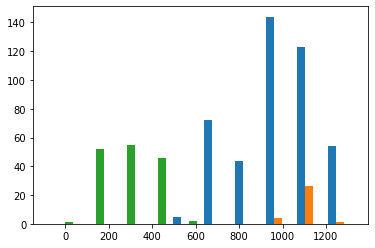

In [127]:
plt.hist([pnp_data_metabolon.loc[pnp1_mar17, 'days_since_storage'], 
          pnp_data_metabolon.loc[pnp1_may18, 'days_since_storage'],
          acs_data_metabolon['days_since_storage']])

## perform the regression

In [167]:
pnp_data_metabolon['const'] = 1
acs_data_metabolon['const'] = 1

In [168]:
pnp_data_metabs = pnp_data_metabolon.loc[:, metabolites.index].dropna()
min_values = pnp_data_metabs.round(5).min()
metabs_with_missing_values = (pnp_data_metabs.round(5) == min_values).sum() > 1
pnp_data_metabs[pnp_data_metabs.round(5) == min_values] = np.nan
acs_data_metabs = acs_data_metabolon.loc[:, metabolites.index].dropna()
acs_data_metabs[acs_data_metabs.round(5) == min_values] = np.nan

mostly_missing_metabs = pnp_data_metabs.notnull().sum().sort_values()[pnp_data_metabs.notnull().sum().sort_values() < 100].index

pnp_mar17_data = pnp_data_metabolon.loc[pnp1_mar17].copy()
pnp_mar17_data.loc[pnp1_mar17, metabolites.index] = pnp_data_metabs.loc[pnp1_mar17, :].values
pnp_may18_data = pnp_data_metabolon.loc[pnp1_may18].copy()
pnp_may18_data.loc[pnp1_may18, metabolites.index] = pnp_data_metabs.loc[pnp1_may18, :].values
acs_may18_data = acs_data_metabolon.copy()
acs_may18_data.loc[acs_data_metabs.index, metabolites.index] = acs_data_metabs.values

In [169]:
all_data = pd.concat((pnp_mar17_data, pnp_may18_data, acs_may18_data), axis=0).loc[:, metabolites.index].dropna(how='all', axis=0)

covariates = ['Age']
pnp_mar17_x = pnp_data_metabolon.loc[pnp1_mar17, ['days_since_storage', 'const'] + covariates]
pnp_mar17_x['cohort'] = 'control_mar17'
pnp_may18_x = pnp_data_metabolon.loc[pnp1_may18, ['days_since_storage', 'const']]
pnp_may18_x['cohort'] = 'control_may18'
acs_may18_x = acs_data_metabolon.dropna(subset=['100000007']).loc[:, ['days_since_storage', 'const']]
acs_may18_x['cohort'] = 'acs_may18'

all_x = pd.concat((pnp_mar17_x, pnp_may18_x, acs_may18_x), axis=0).dropna(how='all', axis=0)
all_x = pd.concat((all_x.drop('cohort', axis=1), pd.get_dummies(all_x['cohort'])), axis=1)


scaler = StandardScaler()
scaler.fit(all_x[['days_since_storage']])
all_x['days_since_storage'] = scaler.transform(all_x[['days_since_storage']]).ravel()

In [170]:
storage_bad_metabs = pd.read_pickle(os.path.join('data/storage_time_bad_metabs_bonf.pkl'))

In [171]:
storage_bad_metabs_new = []
coefs = []
pvals = []
for c in tqdm(set(metabolites.index) - set(mostly_missing_metabs) - set(storage_bad_metabs)):

    ols = OLS(all_data[c], all_x.astype(float), missing='drop')
    res = ols.fit()
    
    coef = res.params.loc['days_since_storage']
    pval = res.pvalues.loc['days_since_storage']
    coefs.append(coef)
    pvals.append(pval)
    
    if pval < 0.05:
        pnp_mar17_data.loc[pnp_mar17_x.index, c] -= (coef * all_x.loc[pnp_mar17_x.index, 'days_since_storage'])
        pnp_may18_data.loc[pnp_may18_x.index, c] -= (coef * all_x.loc[pnp_may18_x.index, 'days_since_storage'])
        acs_may18_data.loc[acs_may18_x.index, c] -= (coef * all_x.loc[acs_may18_x.index, 'days_since_storage'])
    
print((np.array(pvals) < 0.05).sum())

100%|██████████| 928/928 [00:04<00:00, 214.12it/s]

143


In [153]:
merged_data = pd.concat((pnp_mar17_data, pnp_may18_data, acs_may18_data.loc[acs_may18_x.index]), axis=0).loc[:, metabolites.index]
merged_data.fillna(merged_data.min(), inplace=True)

pnp_mar17_data.loc[:, metabolites.index] = merged_data.loc[pnp_mar17_x.index].values
pnp_may18_data.loc[:, metabolites.index] = merged_data.loc[pnp_may18_x.index].values
acs_may18_data.loc[acs_may18_x.index, metabolites.index] = merged_data.loc[acs_may18_x.index].values

In [154]:
pd.concat((pnp_mar17_data, pnp_may18_data), axis=0).to_csv(os.path.join('data/pnp_data_metabolon_storage_residuals.csv'))
acs_may18_data.to_csv(os.path.join('data/acs_data_metabolon_storage_residuals.csv'))